# Apresentação:

O objetivo desse código é estudar sobre o **Risk Parity**, um método quantitativo de otimização de carteira. Basicamente,**Paridade de risco** é um estilo quantitativo de alocação de ativos em portfólio que ajusta a proporção de diferentes classes de ativos no portfólio com base em seu risco, geralmente definido por **volatilidade**, e no apetite ao risco do investidor.

## Documentações:
* Aquisição dos dados: https://python-yahoofinance.readthedocs.io/en/latest/
* https://numpy.org/doc/stable/index.html
* https://docs.scipy.org/doc/scipy/

In [22]:
# Bibiliotecas para análsie dos dados:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Bibliotecas para visualizações:
from matplotlib import pyplot as plt
import seaborn as sns

# Paridade de Risco

A **paridade de risco** é uma técnica avançada de portfólio que tipicamente tem sido domínio de gestores de ativos e fundos de hedge, embora muitos índices passivos também adotem uma abordagem semelhante à alocação. A *Bridgewater Associates* foi pioneira na abordagem de paridade de risco para investimentos em 1996 com o lançamento do fundo de hedge All Weather.

## Fudamentação Matemática:

### Variação da Carteira:

A **variância** da carteira é uma medida do risco total do portfólio com base nas **covariâncias** entre os ativos.

$$Var_{port} = \mathbf{w}^T\boldsymbol{\Sigma}\mathbf{w}$$

Onde, 

* $\mathbf{w}$ é o vetor de pesos do portifólio;
* $\boldsymbol{\Sigma}$ é a matriz de covariância dos ativos.

Essa fórmula pode ser vista como a "diagonalização" da matriz de covariância $\boldsymbol{\Sigma}$ no sentido de que estamos calculando a variância ponderada pela combinação linear dos ativos no portfólio.

### Contribuição Marginal ao Risco:

A contribuição marginal ao risco de cada ativo é a derivada da variância do portfólio em relação ao peso de cada ativo, o que resulta no seguinte:

$$\text{Contribuição Marginal}_i = ({\Sigma}\mathbf{w})$$
 
Isso significa que estamos calculando a contribuição marginal ao risco de cada ativo $i$ com base nos pesos $\mathbf{w}$ atuais e na matriz de covariância.

### Contribuição ao Risco de Cada Ativo:

A **contribuição ao risco** de cada ativo é a contribuição marginal multiplicada pelo peso do ativo e normalizada pela variância total da carteira. 

$$\text{Contribuição de Risco}_i = \frac{w_i({\Sigma}\mathbf{w})_i}{Var_{port}}$$

Isso dá a proporção do risco total da carteira atribuível a cada ativo. A soma das contribuições de risco deve ser $1$.

### Função Objetivo:

A **função objetivo** para otimização é projetada para minimizar as diferenças entre as contribuições ao risco de cada ativo e a média das contribuições. A fórmula utilizada é:

$$\mathcal{L}_{Port} = \sum_i(\text{Contribuição de Risco}_i-\overline{\text{Contribuição de Risco}_i})^2$$

Onde,

* $\text{Contribuição de Risco}_i$ é a contribuição ao risco de cada ativo $i$;
* $\overline{\text{Contribuição de Risco}_i}$ é a **média** das contribuições ao risco de todos os ativos.

A ideia é que, ao minimizar a soma dos quadrados das diferenças, buscamos igualar a contribuição de risco de cada ativo, alcançando a **Paridade de Risco**, **_risk Parity_**.


## Método de Otimização:
Esse processo nada mais é do que um processo de otimização matemática, afinal estamos tratando, como já dito, de um método de otimização de carteira. Para isso, utilizaremos a função `minimize()` do `scipy`, com o método utilizado sendo o `SLSQP`.

### Sequential Least SQuares Programming optimizer (SLSQP)

O **algoritmo de programação de mínimos quadrados sequencial (SLSQP)** é um algoritmo que pode ser usado para minimizar uma função de várias variáveis, sujeito a restrições de igualdade e desigualdade. Ele é ideal para problemas matemáticos em que a função objetivo e as restrições são duas vezes continuamente diferenciáveis. O **algoritmo SLSQP** foi proposto por *Schittkowski* em 1982. Ele envolve a resolução de um subproblema LSQ restrito em cada iteração principal para gerar uma direção de descida. 

* O algoritmo SLSQP usa: O **método quasi-Newton** de *Han-Powell* com uma atualização **BFGS** da matriz B. Uma versão ligeiramente modificada do solver de mínimos quadrados não lineares **NNLS** de *Lawson e Hanson*. 

Os parâmetros do algoritmo SLSQP são:

* **maxiter:** Número máximo de iterações
* **disp:** Definido para True para imprimir mensagens de convergência
* **ftol:** Objetivo de precisão para o valor de f no critério de parada
* **tol:** Tolerância para término 

O **algoritmo SLSQP** está disponível no **SciPy** como `minimize(method='SLSQP')`. 

In [23]:
# Funções utilizadas:
def download_data(tickers, start_date, end_date, key='Adj Close'):
    '''
    Função construída para importar os dados que serão utilizados na análise.

    Parâmetros:
    - tickers: lista de símbolos dos ativos (ex.: ["PETR4.SA", "VALE3.SA"]).
    - start_date: data de início do período (ex.: "2020-01-01").
    - end_date: data de término do período (ex.: "2023-01-01").
    - key: tipo de dado a ser retornado, padrão é 'Adj Close'.

    Retorna:
    - DataFrame contendo os dados do tipo especificado (ex.: preço de fechamento ajustado).
    '''

    # Importando dados:
    data = yf.download(tickers,start=start_date,end=end_date)[key]

    return data

In [24]:
# Função para calcualr os retornos diários:
def calculate_returns(data):
    returns = data.pct_change().dropna() # Calcula a variação percentual dos dias
    return returns

In [25]:
# Função para calcular a volatilidade (desvio padrão):
def calculate_volatility(returns):
    volatility = returns.std()
    return volatility

In [26]:
# Função para calcular a matriz de covariância:
def calculate_covariance_matrix(returns):
    covariance_matrix = returns.cov()
    return covariance_matrix

In [27]:
def risk_parity_weights(covariance_matrix):
    def risk_contribution(weights,covariance_matrix):
        '''
        Variância da Carteira
        '''
        portifolio_var= weights.T@covariance_matrix@weights # Diagonalização?
        marginal_contrib = covariance_matrix@weights
        risk_contrib = marginal_contrib * weights/portifolio_var # Normalizado da variancia da carteira
        return risk_contrib


    def objective_function(weights, covariance_matrix):
        '''
        Função objetivo
        '''

        risk_contrib = risk_contribution(weights, covariance_matrix)
        risk_contrib_diff = risk_contrib - np.mean(risk_contrib)
        return np.sum(risk_contrib_diff**2)


    # Gerando Elementos para o Calculo de Risk Parity:
    num_assets = covariance_matrix.shape[0]
    initial_weights = np.ones(num_assets) / num_assets
    bounds = [(0,1) for _ in range(num_assets)]
    constraints = [{'type':'eq', 'fun':lambda weights: np.sum(weights)-1}]


    # Otimização:
    optimized = minimize(objective_function, initial_weights,args=(covariance_matrix,),
                         method="SLSQP", bounds=bounds,constraints=constraints) # Método de Otimização

    return optimized.x

# Realzando Otimização:

In [28]:
# Elementos dos dados:
tickers = ["PETR4.SA","VALE3.SA","ITUB4.SA","B3SA3.SA","ABEV3.SA"]
start_date = "2020-01-01"
end_date = "2023-01-01"

# Baixando dados históricos:
data = download_data(tickers,start_date,end_date)

[*********************100%***********************]  5 of 5 completed


In [29]:
# Dados:
data

Ticker,ABEV3.SA,B3SA3.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,
2020-01-02 00:00:00+00:00,16.175148,12.357930,30.912512,10.621440,35.130035
2020-01-03 00:00:00+00:00,15.947684,12.001798,30.587379,10.534946,34.871387
2020-01-06 00:00:00+00:00,16.023506,11.886734,30.132179,10.659495,34.664474
2020-01-07 00:00:00+00:00,16.057203,12.270269,29.433140,10.617979,34.916649
2020-01-08 00:00:00+00:00,15.981381,12.237392,28.953552,10.552245,34.923119
...,...,...,...,...,...
2022-12-23 00:00:00+00:00,13.893774,12.415989,22.653631,17.090260,74.970680
2022-12-26 00:00:00+00:00,13.798742,12.481090,22.203972,16.967798,75.656815
2022-12-27 00:00:00+00:00,13.798742,12.043972,22.078068,17.083454,77.463333


In [30]:
data.describe()

Ticker,ABEV3.SA,B3SA3.SA,ITUB4.SA,PETR4.SA,VALE3.SA
count,745.000000,745.000000,745.000000,745.000000,745.000000
mean,13.160505,13.271031,22.715382,11.314267,57.807334
std,1.566924,2.297188,2.691464,4.152946,16.473416
min,9.292285,8.341809,16.956112,3.906061,22.049217
25%,12.286568,11.270691,20.446844,8.054463,40.341660
50%,13.334148,13.005657,22.694553,10.138710,61.482605
75%,14.074033,15.191875,24.690397,14.100868,70.277534
max,17.029501,18.666697,30.912512,23.986860,84.207764


In [31]:
# Calculando os retornos diários:
returns = calculate_returns(data);returns

Ticker,ABEV3.SA,B3SA3.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,
2020-01-03 00:00:00+00:00,-0.014063,-0.028818,-0.010518,-0.008143,-0.007363
2020-01-06 00:00:00+00:00,0.004754,-0.009587,-0.014882,0.011822,-0.005934
2020-01-07 00:00:00+00:00,0.002103,0.032266,-0.023199,-0.003895,0.007275
2020-01-08 00:00:00+00:00,-0.004722,-0.002679,-0.016294,-0.006191,0.000185
2020-01-09 00:00:00+00:00,-0.007907,-0.000448,-0.019932,-0.003279,-0.013146
...,...,...,...,...,...
2022-12-23 00:00:00+00:00,0.013870,0.085737,0.015726,0.047103,0.006647
2022-12-26 00:00:00+00:00,-0.006840,0.005243,-0.019849,-0.007166,0.009152
2022-12-27 00:00:00+00:00,0.000000,-0.035022,-0.005670,0.006816,0.023878


In [32]:
returns.describe()

Ticker,ABEV3.SA,B3SA3.SA,ITUB4.SA,PETR4.SA,VALE3.SA
count,744.000000,744.000000,744.000000,744.000000,744.000000
mean,0.000029,0.000423,-0.000144,0.001174,0.001439
std,0.021961,0.029374,0.023732,0.033088,0.027758
min,-0.157818,-0.161204,-0.179643,-0.296978,-0.151984
25%,-0.012307,-0.015926,-0.012823,-0.012731,-0.014374
50%,-0.000255,-0.000767,-0.000370,0.000764,0.000187
75%,0.011440,0.015373,0.012437,0.016998,0.014662
max,0.098713,0.192446,0.110593,0.222222,0.213579


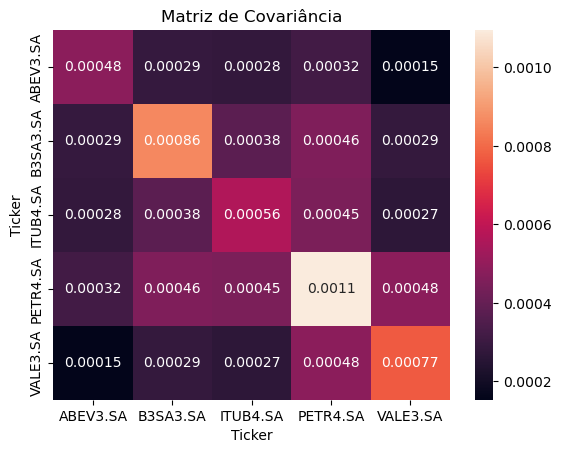

In [33]:
# Calcula a matriz de covariância:
covariance_matrix = calculate_covariance_matrix(returns)

# Visualizando Matriz de Covariança:
sns.heatmap(covariance_matrix, annot=True)
plt.title("Matriz de Covariância")
plt.show()

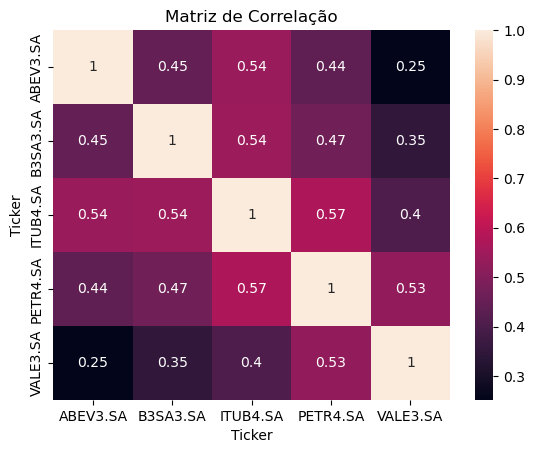

In [34]:
# Calcula a matriz de covariância:
correlation_matrix = returns.corr()

# Visualizando Matriz de Covariança:
sns.heatmap(correlation_matrix, annot=True)
plt.title("Matriz de Correlação")
plt.show()

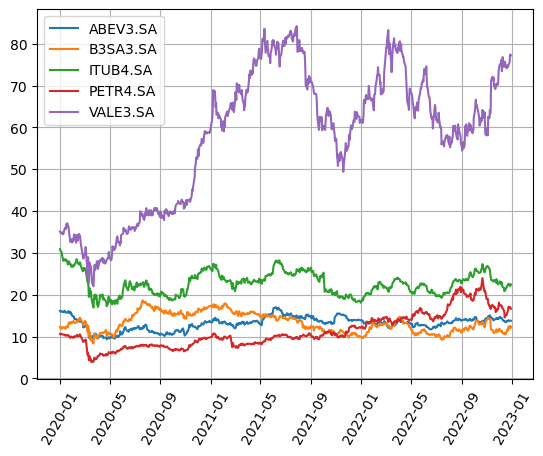

In [35]:
# Analisando Dados:
for col in data.columns:
    plt.plot(data.index,data[col],label=col)
    plt.legend()
    plt.grid()
    plt.xticks(rotation=60)
plt.show()

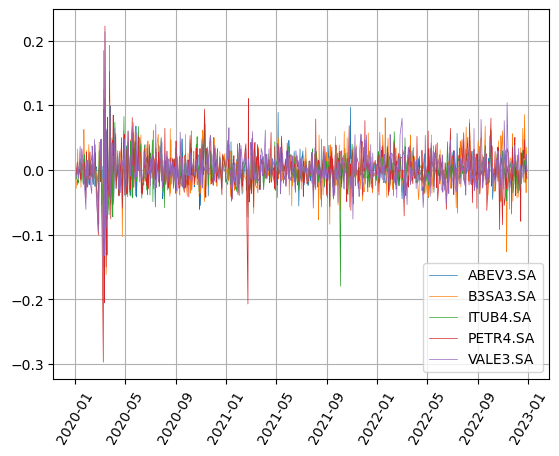

In [41]:
# Analisando Dados:
#plt.figure(figsize=(20,10))
for col in returns.columns:
    plt.plot(returns.index,returns[col],label=col, linewidth=.5)
    plt.legend()
    plt.grid()
    plt.xticks(rotation=60)
plt.show()

In [44]:
# Calcula os pesos da carteira utilizando Risk Parity:
weights = risk_parity_weights(covariance_matrix);weights

array([0.2525358 , 0.18089427, 0.20782056, 0.15080525, 0.20794412])

In [38]:
portifolio_weights = pd.Series(weights,index=tickers).sort_values(ascending=False)
print(f'{round(portifolio_weights,4)*100}') # Porcentagem

PETR4.SA    25.25
ABEV3.SA    20.79
ITUB4.SA    20.78
VALE3.SA    18.09
B3SA3.SA    15.08
dtype: float64


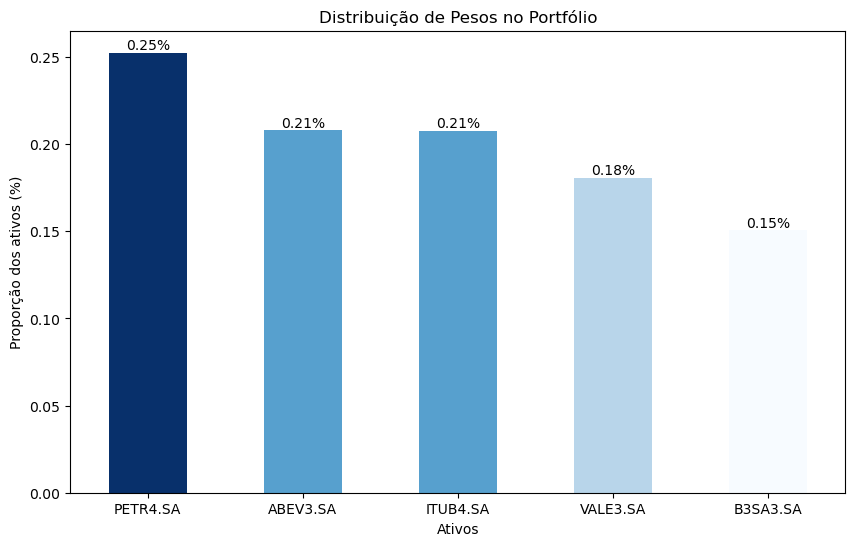

In [39]:
# Normalizando os valores dos pesos para que estejam no intervalo [0, 1]
norm = plt.Normalize(vmin=portifolio_weights.min(), vmax=portifolio_weights.max())

# Usando um colormap para colorir as barras
colors = plt.cm.Blues(norm(portifolio_weights.values))

# Plotando o gráfico de barras com cores variando de acordo com os pesos
ax = portifolio_weights.plot(kind='bar', color=colors, figsize=(10,6))

plt.xlabel('Ativos')
plt.ylabel('Proporção dos ativos (%)')
plt.title('Distribuição de Pesos no Portfólio')
plt.xticks(rotation=0)

# Adicionando os valores em cima de cada barra
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fmt='%.2f%%')

plt.show()